In [1]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
import pickle
import random
from multiprocessing import Pool
import scipy.stats as ss
# import statsmodels.stats.multitest.multipletests
import statsmodels.stats.multitest as smm
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:

data_root = '/data1/APA/Paul_ALS_Data/Mapper_outs_2024/'
os.listdir(data_root)

['Oligo_C9ALSvsCTRL',
 'Astro_C9ALSvsCTRL',
 'Exc_int_negative_control',
 'OPC_negative_control',
 'Exc_deep_sALSvsCTRL',
 'Exc_deep_C9ALSvsCTRL',
 '2024_APANET_data',
 'Astro_negative_control',
 'Inh_sALSvsCTRL',
 'negative_controls',
 'Exc_upper_C9ALSvsCTRL',
 'Exc_int_sALSvsCTRL',
 'Astro_sALSvsCTRL',
 'Oligo_sALSvsCTRL',
 'OPC_C9ALSvsCTRL',
 'Exc_deep_negative_control',
 'Oligo_negative_control',
 'negative_control',
 'Inh_negative_control',
 'Exc_upper_negative_control',
 'OPC_sALSvsCTRL',
 'Inh_C9ALSvsCTRL',
 'Microglia_sALSvsCTRL',
 'Microglia_C9ALSvsCTRL',
 'Exc_int_C9ALSvsCTRL',
 'Exc_upper_sALSvsCTRL',
 'APAlog_volcanos']

In [3]:
# remove anything with 'negative' in and volcanos
files = [x for x in os.listdir(data_root) if 'negative' not in x and 'volcano' not in x]
files

['Oligo_C9ALSvsCTRL',
 'Astro_C9ALSvsCTRL',
 'Exc_deep_sALSvsCTRL',
 'Exc_deep_C9ALSvsCTRL',
 '2024_APANET_data',
 'Inh_sALSvsCTRL',
 'Exc_upper_C9ALSvsCTRL',
 'Exc_int_sALSvsCTRL',
 'Astro_sALSvsCTRL',
 'Oligo_sALSvsCTRL',
 'OPC_C9ALSvsCTRL',
 'OPC_sALSvsCTRL',
 'Inh_C9ALSvsCTRL',
 'Microglia_sALSvsCTRL',
 'Microglia_C9ALSvsCTRL',
 'Exc_int_C9ALSvsCTRL',
 'Exc_upper_sALSvsCTRL']

## prepare fastas

In [8]:
for file in files:
    ref_bed_path = f'{data_root}{file}/PAs_neighbour_region_ref_sequence_2k.bed'
    alt_bed_path = f'{data_root}{file}/PAs_neighbour_region_alt_sequence_2k.bed'
    ref_fa_path = f'{data_root}{file}/PAs_neighbour_region_ref_sequence_2k.fa'
    alt_fa_path = f'{data_root}{file}/PAs_neighbour_region_alt_sequence_2k.fa'
    ref_cmd = f'bedtools getfasta -fi /home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/fasta/genome.fa -bed {ref_bed_path} > {ref_fa_path} -name -s'
    alt_cmd = f'bedtools getfasta -fi /home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/fasta/genome.fa -bed {alt_bed_path} > {alt_fa_path} -name -s'
    subprocess.call(ref_cmd, shell=True)
    subprocess.call(alt_cmd, shell=True)
    print(f'finished {file}')
    

finished Oligo_C9ALSvsCTRL
finished Astro_C9ALSvsCTRL
finished Exc_deep_sALSvsCTRL
finished Exc_deep_C9ALSvsCTRL
finished 2024_APANET_data
finished Inh_sALSvsCTRL
finished Exc_upper_C9ALSvsCTRL
finished Exc_int_sALSvsCTRL
finished Astro_sALSvsCTRL
finished Oligo_sALSvsCTRL
finished OPC_C9ALSvsCTRL
finished OPC_sALSvsCTRL
finished Inh_C9ALSvsCTRL
finished Microglia_sALSvsCTRL
finished Microglia_C9ALSvsCTRL
finished Exc_int_C9ALSvsCTRL
finished Exc_upper_sALSvsCTRL


In [9]:
# functions block
def transcribe_positive_strand(seq):
    """ input is the 5' to 3' coding squence
        so the RNA will be exact sequence except
        U instead of T
    """
    return(seq.replace('T','U'))

def transcribe_negative_strand(seq):
    """ input is the 5' to 3' template squence
        so the function complement and returns
        the reverse of sequence
    """
    complement = {'A': 'U', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement.get(base, base) for base in reversed(seq))
def transcribe_DNA(seq):
    """ input is the 5' to 3' coding squence
        so the RNA will be exact sequence except
        U instead of T
    """
    return(seq.replace('T','U'))

def get_1h_seq(seq):
    """
    This is a simple code to get one-hot representaton of the
    senquences.
    --------------
    Arguments:
    seq: RNA sequence in fasta format
    """
    nt_code = {
        "N": [0, 0, 0, 0],
        "A": [1, 0, 0, 0],
        "C": [0, 1, 0, 0],
        "G": [0, 0, 1, 0],
        "U": [0, 0, 0, 1],
    }

    seq_1h = [nt_code[nt] for nt in seq]
    return np.array(seq_1h)

def makes_seqs_ready(seq,max_len,left_pad_max):
    """
    takes in the sequence, max len and max left pad
    and returns the one hot representation of sequence with maximum pad
    """
    if len(seq) < max_len:
        diff = max_len - len(seq)
        lp = random.randint(0, left_pad_max)
        lp = min(lp, diff)
        seq = get_1h_seq(
            "N" * (lp) + str(seq) + "N" * (max_len - len(seq) - lp)
        )
    else:
        seq = get_1h_seq(str(seq))
    seq = np.array(seq, dtype=np.int8).swapaxes(0, 1)
    
    return seq


def rank_to_normal(rank, c, n):
    # Standard quantile function
    x = (rank - c) / (n - 2*c + 1)
    return ss.norm.ppf(x)

def rank_INT(series, c=3.0/8, stochastic=True):
    """ Perform rank-based inverse normal transformation on pandas series.
        If stochastic is True ties are given rank randomly, otherwise ties will
        share the same value. NaN values are ignored.
        Args:
            param1 (pandas.Series):   Series of values to transform
            param2 (Optional[float]): Constand parameter (Bloms constant)
            param3 (Optional[bool]):  Whether to randomise rank of ties
        
        Returns:
            pandas.Series
    """

    # Check input
    #assert(isinstance(series, pd.Series))
    #assert(isinstance(c, float))
    #assert(isinstance(stochastic, bool))

    # Set seed
    np.random.seed(123)

    # Take original series indexes
    orig_idx = series.index

    # Drop NaNs
    series = series.loc[~pd.isnull(series)]

    # Get ranks
    if stochastic == True:
        # Shuffle by index
        series = series.loc[np.random.permutation(series.index)]
        # Get rank, ties are determined by their position in the series (hence
        # why we randomised the series)
        rank = ss.rankdata(series, method="ordinal")
    else:
        # Get rank, ties are averaged
        rank = ss.rankdata(series, method="average")

    # Convert numpy array back to series
    rank = pd.Series(rank, index=series.index)

    # Convert rank to normal distribution
    transformed = rank.apply(rank_to_normal, c=c, n=len(rank))
    
    return transformed[orig_idx]

def get_sig_lfc(df, name):
    tmp_df =  df.loc[df['switch_name'] == name]
    lfc = round(float(tmp_df['LFC_rand_INT']),4)
    return(lfc)
    
# def get_sig_mult(val):
#     if val > 1.3:
#         return 1
#     else:
#         return 0

In [10]:
c9ALS_ct = [ct for ct in os.listdir(data_root) if '_C9ALS' in ct ]
sALS_ct = [ct for ct in os.listdir(data_root) if '_sALS' in ct ]
print(len(c9ALS_ct), len(sALS_ct))
print(c9ALS_ct[1:3])
print(sALS_ct[1:3])

8 8
['Astro_C9ALSvsCTRL', 'Exc_deep_C9ALSvsCTRL']
['Inh_sALSvsCTRL', 'Exc_int_sALSvsCTRL']


In [11]:
# get the sequences for the C9 and sALS
c9_sequences_dict = {}
for ct_cn in c9ALS_ct:
    inp_fa_1 = data_root + "/{}/PAs_neighbour_region_alt_sequence_2k.fa".format(ct_cn)
    inp_fa_1 = SeqIO.parse(inp_fa_1, "fasta")
    inp_fa_2 = data_root + "/{}/PAs_neighbour_region_ref_sequence_2k.fa".format(ct_cn)
    inp_fa_2 = SeqIO.parse(inp_fa_2, "fasta")
    # iterate over the two files and add the sequences to the dictionary
    for rec1,rec2 in zip(inp_fa_1,inp_fa_2):
        if rec1.id not in c9_sequences_dict:
            c9_sequences_dict[rec1.id[:-2]] = str(rec1.seq) + str(rec2.seq)
        else:
            continue

    
print(len(c9_sequences_dict))

18755


In [12]:
sALS_sequences_dict = {}
for ct_cn in sALS_ct:
    inp_fa_1 = data_root + "/{}/PAs_neighbour_region_alt_sequence_2k.fa".format(ct_cn)
    inp_fa_1 = SeqIO.parse(inp_fa_1, "fasta")
    inp_fa_2 = data_root + "/{}/PAs_neighbour_region_ref_sequence_2k.fa".format(ct_cn)
    inp_fa_2 = SeqIO.parse(inp_fa_2, "fasta")
    # iterate over the two files and add the sequences to the dictionary
    for rec1,rec2 in zip(inp_fa_1,inp_fa_2):
        if rec1.id not in sALS_sequences_dict:
            sALS_sequences_dict[rec1.id[:-2]] = str(rec1.seq) + str(rec2.seq)
        else:
            continue
    
print(len(sALS_sequences_dict))

22987


In [13]:
# get the celltype names for C9 and sALS
c9_celltypes = [e.split('_C')[0] for e in c9ALS_ct]
c9_celltypes = sorted(c9_celltypes)
sALS_celltyes = [e.split('_sA')[0] for e in sALS_ct]
sALS_celltyes = sorted(sALS_celltyes)
print(c9_celltypes)
print(sALS_celltyes)

['Astro', 'Exc_deep', 'Exc_int', 'Exc_upper', 'Inh', 'Microglia', 'OPC', 'Oligo']
['Astro', 'Exc_deep', 'Exc_int', 'Exc_upper', 'Inh', 'Microglia', 'OPC', 'Oligo']


In [14]:
c9ALS_transcribed_sequences = {}
for key,value in c9_sequences_dict.items():
    c9ALS_transcribed_sequences[key] = transcribe_DNA(value)
# for sALS
sALS_transcribed_sequences = {}
for key,value in sALS_sequences_dict.items():
    sALS_transcribed_sequences[key] = transcribe_DNA(value)

In [15]:
# c9ALS
keys = list(c9ALS_transcribed_sequences.keys())
seqs = [c9ALS_transcribed_sequences[k] for k in keys]
indexes = list(range(len(keys)))

c9ALS_seqs_data = pd.DataFrame([indexes, keys, seqs]).T
c9ALS_seqs_data.columns = ['switch_index', 'switch_id', 'sequence']

c9ALS_seqs_data.to_csv(data_root + '2024_APANET_data/C9ALS_All_sequences_2k.csv')
# sALS
keys = list(sALS_transcribed_sequences.keys())
seqs = [sALS_transcribed_sequences[k] for k in keys]
indexes = list(range(len(keys)))

sALS_seqs_data = pd.DataFrame([indexes, keys, seqs]).T
sALS_seqs_data.columns = ['switch_index', 'switch_id', 'sequence']
sALS_seqs_data.to_csv(data_root + '2024_APANET_data/sALS_All_sequences_2k.csv')
#####

In [16]:
c9ALS_seqs_data.head()

,switch_index,switch_id,sequence
0,0,chr12:AACS:125124284:125140928:+,GUGAGGCGGGACAAACUUGUCUUCCUCACACCCAUCUUACUUCCUC...
1,1,chr12:AACS:125124284:125143316:+,UUGUAAAAGGAUGCUCGCACCAAGUGUUCUGUAGGCUUGGGGAGGG...
2,2,chr12:AACS:125140928:125143316:+,UUGUAAAAGGAUGCUCGCACCAAGUGUUCUGUAGGCUUGGGGAGGG...
3,3,chr1:ABCD3:94477255:94518529:+,UUCUAGCAAGAUAGUCUUCAGUUUCAUUUUCCUGUGCCCUGUGGUA...
4,4,chr1:ABCD3:94477255:94518663:+,CACAGUAAUACUCAUUCCUUGUGUGUGUCUUGGAGUGCAUUUGACU...


In [17]:
sALS_seqs_data.head()

,switch_index,switch_id,sequence
0,0,chr6:AARS2:44298731:44299560:-,CUGCUAAACAGGCUACUGCCCCAGUGGCCAGGAUGCUGCUUUGCAA...
1,1,chr6:AARS2:44298731:44300312:-,UCAUAGCUCACUGCGGCCUUGAAUUCCUGGGCAAAGUGAUUUUCCC...
2,2,chr6:AARS2:44299560:44300312:-,UCAUAGCUCACUGCGGCCUUGAAUUCCUGGGCAAAGUGAUUUUCCC...
3,3,chr4:AASDH:56338290:56382473:-,CAGCUGAGGCACAAGAACCGCUUGAACCUGGGAGGCGGAGGUUGCA...
4,4,chr6:ABCF1:30579988:30591312:+,CAACCAAUAACCUGGACAUAGAGUCUAUUGAUGCUCUAGGGGAGGC...


In [18]:
# 10% FDR thresholds from empirical analysis
fdr_thresholds = {"Astro": 3.493186e-04, 
                  "Exc_deep" : 1.061938e-06, "Exc_int": 5.271816e-07, 
                  "Exc_upper":1.910463e-05, "Inh": 1.446201e-04, "Microglia": 1.825780e-05,
                  "Oligo": 5.378499e-03, "OPC": 2.278128e-04}

In [19]:
# dataframe with these columns: 
# switch_id, switch_idx,  condition, celltype, APA_lfc, pvalue (p_ConditionALS_pathology_adj)
out_df = pd.DataFrame(columns=['switch_name', 'condition', 'celltype', 'LFC_rand_INT', 'pval_BY'])
for ct in c9_celltypes:
    c9_df = data_root + ct + "_C9ALSvsCTRL/APAlog_res_metadata_added.tsv"
    c9_df = pd.read_csv(c9_df, sep='\t')
    c9_df = c9_df[c9_df['p_devtest'] < fdr_thresholds[ct]]
    c9_df = c9_df[~pd.isnull(c9_df['LFC_PA_Usage'])]
    c9_df = c9_df[~pd.isnull(c9_df['p_ConditionALS_pathology'])]
    c9_df['pval_BY'] = smm.multipletests(c9_df['p_ConditionALS_pathology'], method='fdr_by')[1]
    c9_df['LFC_rand_INT'] = rank_INT(c9_df['LFC_PA_Usage']) 
    # get the sequences from c9ALS_seqs_data, based on switch_id
    c9_df['sequence'] = c9_df['switch_name'].apply(lambda x: c9ALS_transcribed_sequences[x])
    c9_df['celltype'] = ct
    c9_df['condition'] = 'C9ALS'
    out_df = pd.concat([out_df, c9_df[['switch_name', 'condition', 'celltype', 'LFC_rand_INT', 'pval_BY', 'sequence']]])                       
    #
    sALS_df = data_root + ct + "_sALSvsCTRL/APAlog_res_metadata_added.tsv"
    sALS_df = pd.read_csv(sALS_df, sep='\t')
    sALS_df = sALS_df[sALS_df['p_devtest'] < FDR_10]
    sALS_df = sALS_df[~pd.isnull(sALS_df['LFC_PA_Usage'])] ## remove NaNs if any
    sALS_df = sALS_df[~pd.isnull(sALS_df['p_ConditionALS_pathology'])]
    sALS_df['pval_BY'] = smm.multipletests(sALS_df['p_ConditionALS_pathology'], method='fdr_by')[1]
    sALS_df['LFC_rand_INT'] = rank_INT(sALS_df['LFC_PA_Usage'])
    # get the sequences from sALS_seqs_data, based on switch_id
    sALS_df['sequence'] = sALS_df['switch_name'].apply(lambda x: sALS_transcribed_sequences[x])
    sALS_df['celltype'] = ct
    sALS_df['condition'] = 'sALS'
    out_df = pd.concat([out_df, sALS_df[['switch_name', 'condition', 'celltype', 'LFC_rand_INT', 'pval_BY', 'sequence']]])
out_df.head()

/home/aiden/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()
/home/aiden/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,LFC_rand_INT,celltype,condition,pval_BY,sequence,switch_name
7,0.414703,Astro,C9ALS,0.000033,UUGUAAAAGGAUGCUCGCACCAAGUGUUCUGUAGGCUUGGGGAGGG...,chr12:AACS:125140928:125143316:+
64,0.703658,Astro,C9ALS,0.000070,CAAUCUCAGCUCAAUGCAACCUCUGCCUCCCAGGUUCAAGUGAUUC...,chr2:AAMP:218264129:218269400:-
75,-1.138053,Astro,C9ALS,0.001610,CUGCUAAACAGGCUACUGCCCCAGUGGCCAGGAUGCUGCUUUGCAA...,chr6:AARS2:44298731:44299560:-
76,-0.889937,Astro,C9ALS,0.163851,UAAUUUUUACUAGACAGAAUUUGGUAGCCAGGGAGCCCUUGAUUUG...,chr6:AARS2:44298731:44299738:-
77,-1.122560,Astro,C9ALS,0.017341,UCAUAGCUCACUGCGGCCUUGAAUUCCUGGGCAAAGUGAUUUUCCC...,chr6:AARS2:44298731:44300312:-


In [20]:
# reindex out_df
out_df.index = range(len(out_df))

In [21]:
out_df['one_hot'] = out_df['sequence'].apply(makes_seqs_ready, args=(4000,10))

In [4]:
# this cell is added  later for reproducing the barplot
out_df = pd.read_csv(data_root + '2024_APANET_data/2024_APANET_All_data.csv')
out_df.head()

,Unnamed: 0,LFC_rand_INT,celltype,condition,pval_BY,sequence,switch_name,one_hot,APA_LFC
0,0,0.414703,Astro,C9ALS,0.000033,UUGUAAAAGGAUGCUCGCACCAAGUGUUCUGUAGGCUUGGGGAGGG...,chr12:AACS:125140928:125143316:+,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 1]\n [0 0 ...,0.414703
1,1,0.703658,Astro,C9ALS,0.000070,CAAUCUCAGCUCAAUGCAACCUCUGCCUCCCAGGUUCAAGUGAUUC...,chr2:AAMP:218264129:218269400:-,[[0 1 1 ... 1 0 1]\n [1 0 0 ... 0 0 0]\n [0 0 ...,0.703658
2,2,-1.138053,Astro,C9ALS,0.001610,CUGCUAAACAGGCUACUGCCCCAGUGGCCAGGAUGCUGCUUUGCAA...,chr6:AARS2:44298731:44299560:-,[[0 0 0 ... 1 1 0]\n [1 0 0 ... 0 0 0]\n [0 0 ...,-1.138053
3,3,-0.889937,Astro,C9ALS,0.163851,UAAUUUUUACUAGACAGAAUUUGGUAGCCAGGGAGCCCUUGAUUUG...,chr6:AARS2:44298731:44299738:-,[[0 1 1 ... 1 1 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,-0.889937
4,4,-1.122560,Astro,C9ALS,0.017341,UCAUAGCUCACUGCGGCCUUGAAUUCCUGGGCAAAGUGAUUUUCCC...,chr6:AARS2:44298731:44300312:-,[[0 0 1 ... 1 1 0]\n [0 1 0 ... 0 0 0]\n [0 0 ...,-1.122560


In [5]:
df = out_df.copy()

pivot_df = df.pivot_table(index=['switch_name', 'celltype'], columns='condition', values='LFC_rand_INT', aggfunc='mean').dropna()

correlations = {}
p_vals = {}
for celltype in pivot_df.index.get_level_values('celltype').unique():
    print(celltype)
    c9 = pivot_df.loc[pivot_df.index.get_level_values('celltype') == celltype]['C9ALS']
    sALS = pivot_df.loc[pivot_df.index.get_level_values('celltype') == celltype]['sALS']
    print(ss.pearsonr(c9, sALS))
    correlations[celltype] = ss.pearsonr(c9, sALS)[0]
    p_vals[celltype] = ss.pearsonr(c9, sALS)[1]

Astro
(0.721911685323837, 6.265301546485648e-166)
Inh
(0.8020879163321836, 0.0)
Exc_deep
(0.817427818655108, 3.5402366936750634e-150)
Exc_int
(0.869889421373557, 7.244448048271233e-176)
OPC
(0.6549089627291347, 5.348980248424737e-159)
Exc_upper
(0.8387253508714428, 0.0)
Oligo
(0.7247214038910368, 4.700421702617904e-200)
Microglia
(0.6862923647852959, 7.365025629639642e-199)


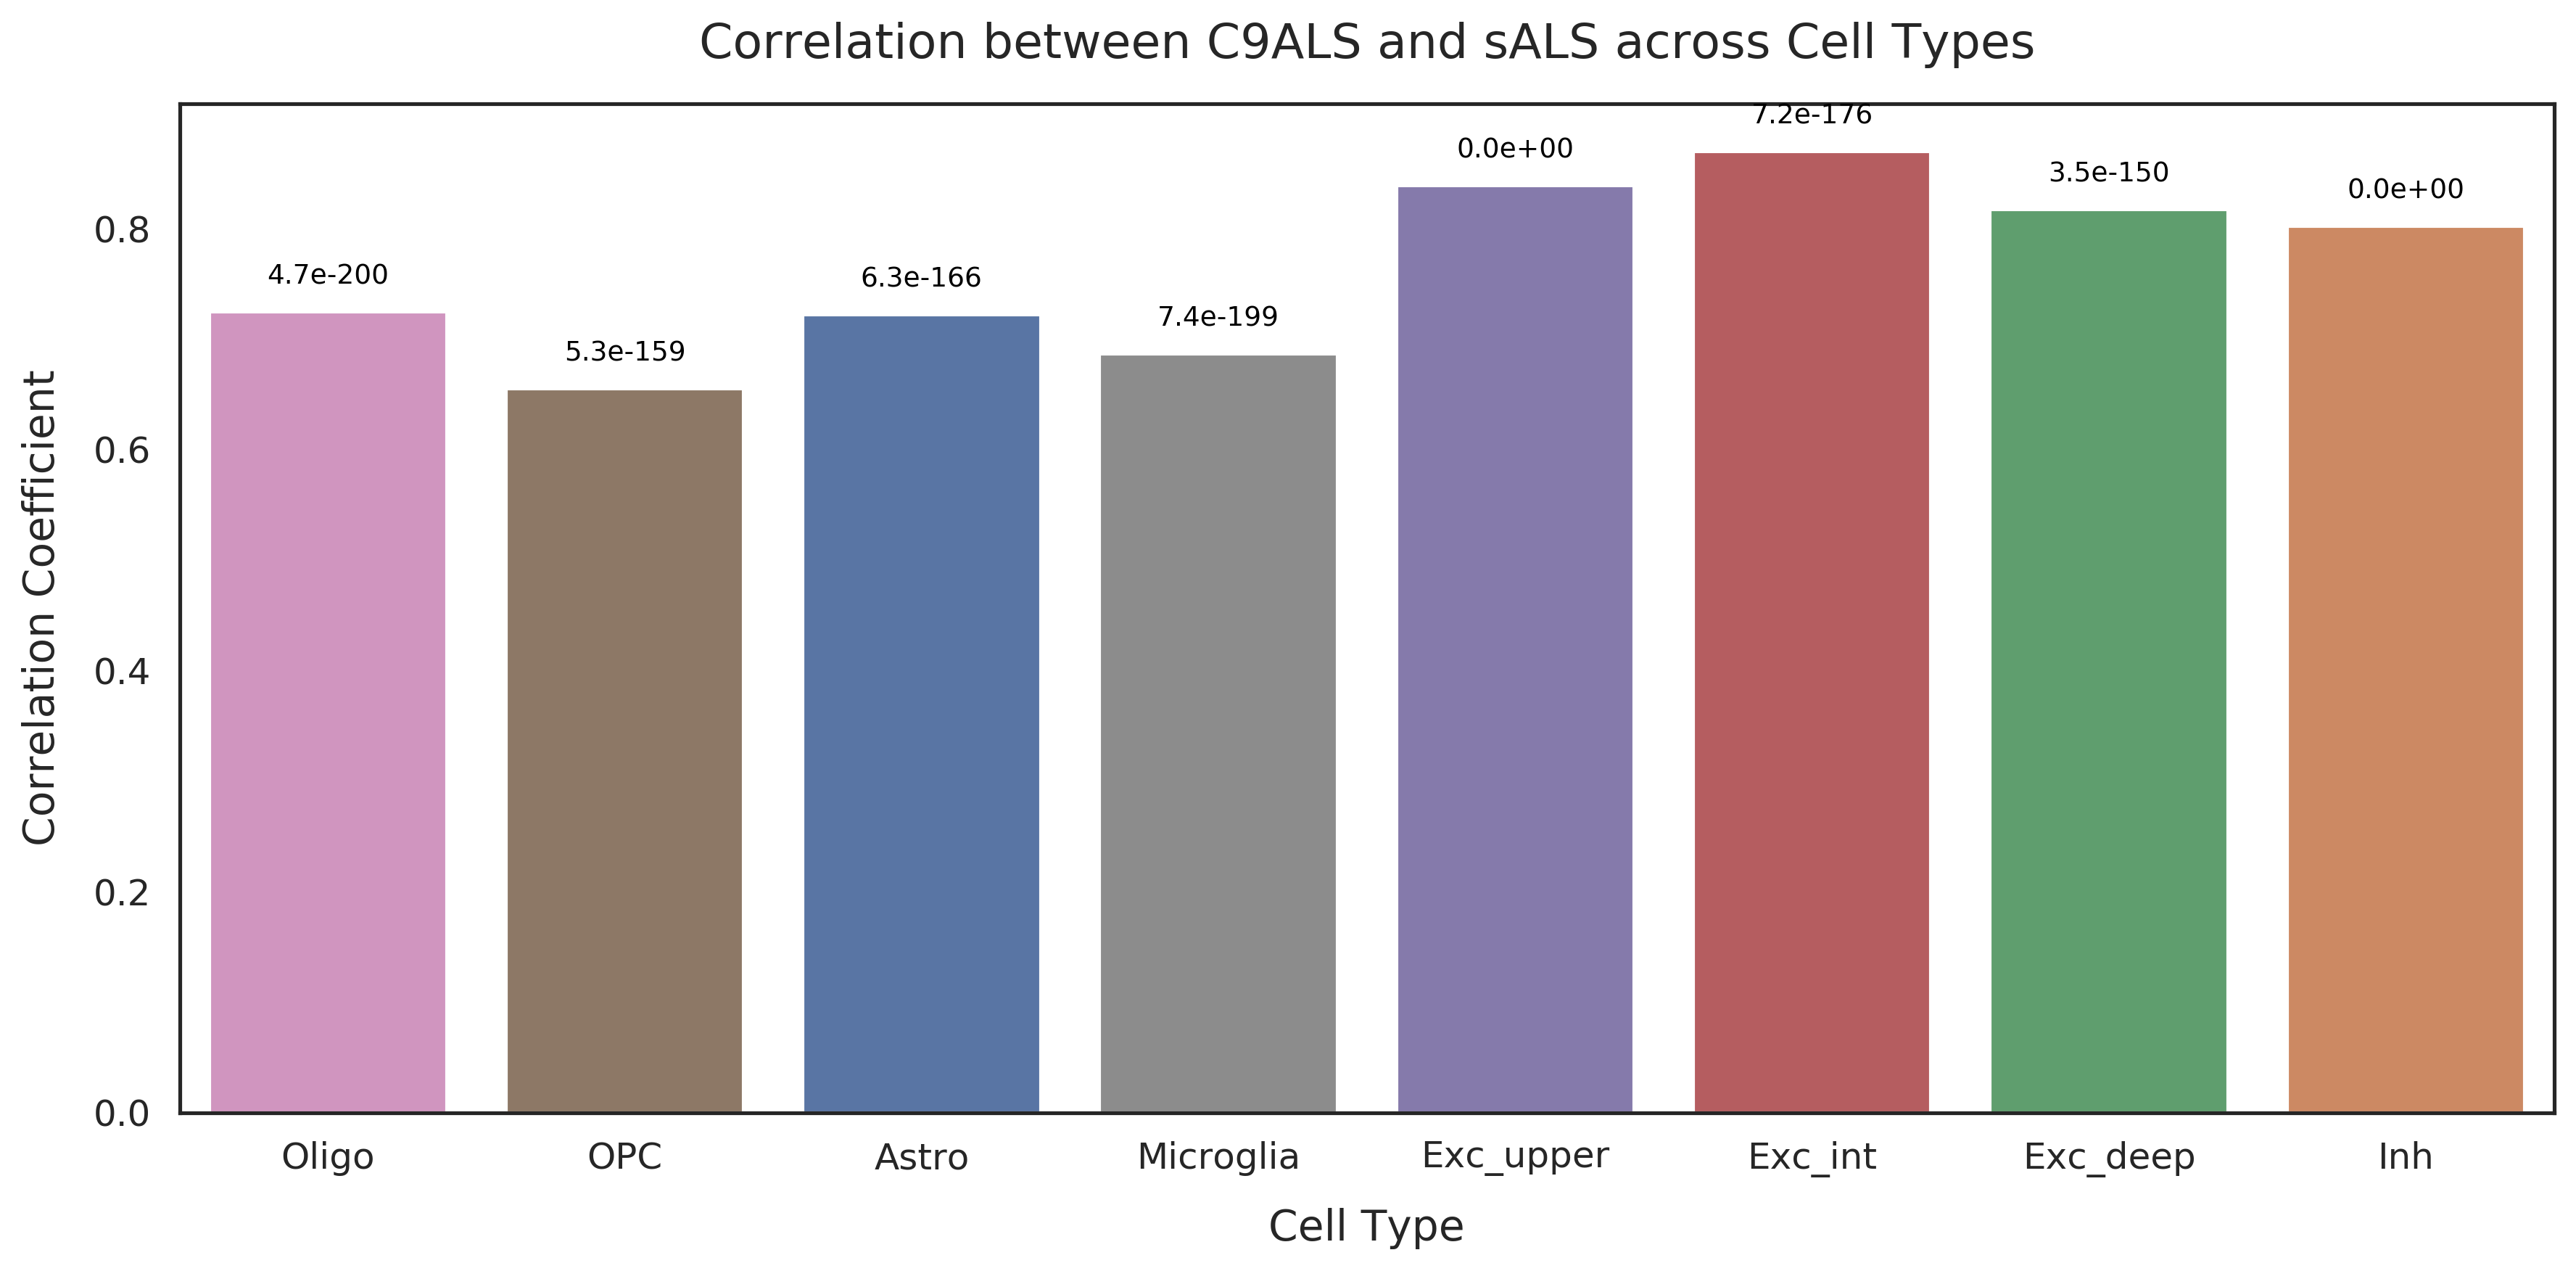

In [7]:
# Extract data for plotting
celltypes = ['Oligo','OPC','Astro','Microglia','Exc_upper','Exc_int', 'Exc_deep','Inh']
colors = ['#da8bc3', '#937860', '#4c72b0','#8c8c8c','#8172b3','#c44e52','#55a868', '#dd8452']
correlation_coefficients = [correlations[v] for v in celltypes]
p_values = [p_vals[v] for v in celltypes]

# Convert p-values to strings for display
p_value_strings = [f'{p:.1e}' for p in p_values]

# Set up the plot
sns.set(style="white")
plt.figure(figsize=(12, 6), dpi=300)

# Create bar plot
bar_plot = sns.barplot(x=celltypes, y=correlation_coefficients, palette=colors)

# Add p-values on top of the bars
for i, (correlation, pval) in enumerate(zip(correlation_coefficients, p_value_strings)):
    bar_plot.text(i, correlation + 0.02, pval, ha='center', va='bottom', fontsize=9, color='black')

# Label the axes and set title
plt.xlabel('Cell Type', fontsize=14, labelpad=10)
plt.ylabel('Correlation Coefficient', fontsize=14, labelpad=10)
plt.title('Correlation between C9ALS and sALS across Cell Types', fontsize=16, pad=15)

# Improve tick parameters for both axes
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.savefig('sALS_C9ALS_apa_correlation.pdf', format='pdf')
# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()


In [27]:
# make new column APA_LFC,  if pval_BY is less than 0.05, then APA_LFC is LFC_rand_INT, else 0, don't use functions
# out_df['APA_LFC'] = out_df.apply(lambda x: x['LFC_rand_INT'] if x['pval_BY'] < 0.05 else 0, axis=1)
out_df['APA_LFC'] =  out_df['LFC_rand_INT'] 
out_df.head()

,LFC_rand_INT,celltype,condition,pval_BY,sequence,switch_name,one_hot,APA_LFC
0,0.414703,Astro,C9ALS,0.000033,UUGUAAAAGGAUGCUCGCACCAAGUGUUCUGUAGGCUUGGGGAGGG...,chr12:AACS:125140928:125143316:+,"[[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,...",0.414703
1,0.703658,Astro,C9ALS,0.000070,CAAUCUCAGCUCAAUGCAACCUCUGCCUCCCAGGUUCAAGUGAUUC...,chr2:AAMP:218264129:218269400:-,"[[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,...",0.703658
2,-1.138053,Astro,C9ALS,0.001610,CUGCUAAACAGGCUACUGCCCCAGUGGCCAGGAUGCUGCUUUGCAA...,chr6:AARS2:44298731:44299560:-,"[[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,...",-1.138053
3,-0.889937,Astro,C9ALS,0.163851,UAAUUUUUACUAGACAGAAUUUGGUAGCCAGGGAGCCCUUGAUUUG...,chr6:AARS2:44298731:44299738:-,"[[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,...",-0.889937
4,-1.122560,Astro,C9ALS,0.017341,UCAUAGCUCACUGCGGCCUUGAAUUCCUGGGCAAAGUGAUUUUCCC...,chr6:AARS2:44298731:44300312:-,"[[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",-1.122560


In [28]:
out_df['one_hot'][1].shape
# chack the shape[1] of all the one_hot sequences is 4000
for i in range(out_df.shape[0]):
    if out_df['one_hot'][i].shape[1] != 4000:
        print(i)
        print(out_df['one_hot'][i].shape[1])

In [29]:
# check the length of all the sequences is 4000
for i in range(out_df.shape[0]):
    if len(out_df['sequence'][i]) != 4000:
        print(i)
        print(len(out_df['sequence'][i]))

In [30]:
# save the out_df
out_df.to_csv(data_root + '2024_APANET_data/2024_APANET_All_data.csv')
np.save(f'{data_root}/2024_APANET_data/2024_APANET_All_data.npy', out_df.to_numpy())

In [ ]:
print(out_df.shape)

In [31]:
print(len(out_df['sequence'].unique()))

31513


In [32]:
control_rbps = pd.read_csv('/home/aiden/codes/APA_stuff/APA_ALS_paper_rev_2024/data/control_ct_RBP_profiles.tsv', sep='\t')
control_rbps = control_rbps.rename(columns={'Micro': 'Microglia'})
C9ALS_rbps = pd.read_csv('/home/aiden/codes/APA_stuff/APA_ALS_paper_rev_2024/data/C9ALS_ct_RBP_profiles.tsv', sep='\t')
sALS_rbps = pd.read_csv('/home/aiden/codes/APA_stuff/APA_ALS_paper_rev_2024/data/sALS_ct_RBP_profiles.tsv', sep='\t')
C9ALS_rbps = C9ALS_rbps.rename(columns={'Micro': 'Microglia'})
sALS_rbps = sALS_rbps.rename(columns={'Micro': 'Microglia'})

# 5 fold cross-validation data split

In [33]:
from sklearn.model_selection import GroupKFold

unique_sequences = out_df['sequence'].unique()
n_splits = 5

# Initialize GroupKFold
group_kfold = GroupKFold(n_splits=n_splits)

for fold, (train_seq_idx, test_seq_idx) in enumerate(group_kfold.split(unique_sequences, groups=unique_sequences)):
    # Select the training and test sequences
    train_sequences = unique_sequences[train_seq_idx]
    test_sequences = unique_sequences[test_seq_idx]

    # Filter the original dataframe based on the sequences
    train_df = out_df[out_df['sequence'].isin(train_sequences)]
    potential_test_df = out_df[out_df['sequence'].isin(test_sequences)]

    # Apply the test condition
    train_df['RBP_profile'] = train_df['celltype'].apply(lambda x: np.array(control_rbps[x]))
    potential_test_df['RBP_profile'] = potential_test_df['celltype'].apply(lambda x: np.array(control_rbps[x]))

    # Save the training and test data for each fold
    np.save(f'{data_root}/2024_APANET_data/22May/random/train_fold_{fold}.npy', train_df.to_numpy())
    np.save(f'{data_root}/2024_APANET_data/22May/random/test_fold_{fold}.npy', potential_test_df.to_numpy())
    print(f"Fold {fold}: Train samples: {len(train_df)}, Test samples: {len(potential_test_df)}")

    # Check for data leakage
    train_seqs = set(train_df['sequence'])
    test_seqs = set(potential_test_df['sequence'])
    intersection = train_seqs.intersection(test_seqs)
    print(f"Fold {fold}: Number of overlapping sequences: {len(intersection)}")

/home/aiden/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/aiden/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fold 0: Train samples: 46147, Test samples: 11492
Fold 0: Number of overlapping sequences: 0
Fold 1: Train samples: 46127, Test samples: 11512
Fold 1: Number of overlapping sequences: 0
Fold 2: Train samples: 46078, Test samples: 11561
Fold 2: Number of overlapping sequences: 0
Fold 3: Train samples: 45977, Test samples: 11662
Fold 3: Number of overlapping sequences: 0
Fold 4: Train samples: 46227, Test samples: 11412
Fold 4: Number of overlapping sequences: 0


In [ ]:
# commands to run:
python train_script.py --train_data /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/train_fold_2.npy --valid_data  /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/test_fold_2.npy --modelfile ~/projects/APA/codes/CNN_MATTs/APA-Net_2024_05_08_v2/model_outs/significant/model_out_fold2.pt --project_name "APA-Net_transformer_V1_24May" --device "cuda:2" --use_wandb "True" --batch_size 256 --epochs 60

# fold 0
python train_script.py --train_data /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/train_fold_0.npy --valid_data  /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/test_fold_0.npy --modelfile ~/projects/APA/codes/CNN_MATTs/APA-Net_2024_05_08_v2/model_outs/significant/model_out_fold0.pt --project_name "APA-Net_transformer_V1_24May" --device "cuda:3" --use_wandb "True" --batch_size 256 --epochs 60


# fold 1, 3 , 4 just signifcant ############################
python train_script.py --train_data /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/train_fold_1.npy --valid_data  /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/test_fold_1.npy --modelfile ~/projects/APA/codes/CNN_MATTs/APA-Net_2024_05_08_v2/model_outs/significant/model_out_fold1.pt --project_name "APA-Net_transformer_V1_24May" --device "cuda:1" --use_wandb "True" --batch_size 256 --epochs 60

python train_script.py --train_data /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/train_fold_3.npy --valid_data  /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/test_fold_3.npy --modelfile ~/projects/APA/codes/CNN_MATTs/APA-Net_2024_05_08_v2/model_outs/significant/model_out_fold3.pt --project_name "APA-Net_transformer_V1_24May" --device "cuda:0" --use_wandb "True" --batch_size 256 --epochs 60

python train_script.py --train_data /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/train_fold_4.npy --valid_data  /data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/test_fold_4.npy --modelfile ~/projects/APA/codes/CNN_MATTs/APA-Net_2024_05_08_v2/model_outs/significant/model_out_fold4.pt --project_name "APA-Net_transformer_V1_24May" --device "cuda:2" --use_wandb "True" --batch_size 256 --epochs 60
